# T-test при тестировании зависимых выборок

Привет, Хабр! Теме АБ-тестирования посвящено достаточно много статей~, и вот держите ещё одну~. Тема экспериментов для выявления эффективности внедрения доработок популярна не последний год и эта тема, скорее всего, освещена уже со всех возможных сторон:
* Как определить размер [одной](https://habr.com/ru/articles/339798/) выборки и [множества](https://habr.com/ru/companies/X5Tech/articles/763656/)?
* Что делать, если размер выборки [мал](https://habr.com/ru/companies/X5Tech/articles/801527/)?
* Как [лучше](https://habr.com/ru/companies/X5Tech/articles/780690/) разбить выборки
* Воспользоваться ли классикой или [бутстрепом](https://habr.com/ru/companies/X5Tech/articles/679842/)?
* Как повысить [чувствительность](https://habr.com/ru/companies/X5Tech/articles/596279/)?
* и дальше [повысить чувствительность](https://habr.com/ru/companies/X5Tech/articles/780270/) и [ещё](https://habr.com/ru/companies/X5Tech/articles/768008/)...

Но большинство этих статей объединяет одна черта -- они рассматривают случай сравнения **независимых выборок**. Найти же информацию по тестированию зависимых оказалось нетривиальной задачей.

Что же такое тестирование зависимых выборок и почему так мало информации? 

Самый распространённый пример тестирования зависимых выборок, на который я натыкался, выглядит примерно так:

"... пусть выбрана группа людей X и на периоде T1 замерена их характеристика. Затем на периоде T2 они подвергаются воздействию и характеристика замеряется повторно. Таким образом мы изучаем воздействие в контексте одних и тех же людей, поэтому выборки (а вообще говоря выборка) являются зависимыми. Для этого воспользуемся ..."

Такой пример на практике встречается достаточно редко, так как обычно с течением времени на наши объекты исследования влияет множество факторов помимо нашего воздействия. Но сам случай тестирования зависимых выборок на практике встречается достаточно часто и, возможно, даже чаще, чем тестирование независимых выборок. Ведь само понятие "независимые выборки" подразумевает случайный подбор групп из генеральной совокупности, а такой способ в конкретном случае может подобрать весьма различающиеся между собой группы.

А в случае, если мы дизайним какой-то важный эксперимент, кто из нас не посмотрит на то, как у нас различаются подобранные группы до эксперимента? А ещё лучше посмотрим на то, чтобы они ещё и сходились на протяжении какого-то периода в динамике. А если они не сходятся, то "случайно" переподберём ещё разок, и ещё, пока не получим удовлетворительный результат. А если проверять долго, то лучше заранее задумаемся о том, каким бы таким алгоритмом найти похожие друг на друга объекты и распределить их в обе наших группы?

И вот в таком случае наше предположение о независимости начинает сыпаться. Конечно, оно разрушается не полностью и обычно возникает следующая ситуация: мы проводим множество АА-тестов с нашим алгоритмом подбора, получаем ошибку первого рода меньше ожидаемой, и принимаем решение из разряда "ну, меньше не больше, значит, хуже точно не будет, катим".

Поэтому данную статью я бы хотел посвятить именно разбору случая тестирования зависимых выборок на простых примерах.

P.S. Я не против комментариев "эта тема уже 100500 раз разбиралась", только прошу, подкрепляйте эти слова соответствующими ссылками. Так мы сделаем эту статью только полезнее)

## Классический случай

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics

Предлагаю начать наш разбор с самого классического случая. Предположим, что интересующая нас метрика на генеральной совокупности распределена нормально $target \sim N(\mu, \sigma)$, где $\mu = 1000$, $\sigma = 100$.

In [2]:
mu = 1000
sigma = 100

dist_gen = stats.norm(loc=mu, scale=sigma)

Мы хотим провести АБ-эксперимент на таком множестве, и для этого нам нужно зафиксировать основные параметры этого эксперимента. Предположим, чтоЖ
* Мы ожидаем получить эффект $\varepsilon = 5$
* Мы готовы выдать желаемое за действительное не более чем в $5\%$ случаев ($\alpha = 0.05$)
* Мы готовы закрыть глаза на значимость нашей работы не более, чем в $20\%$ случаев ($\beta = 0.2$)

In [3]:
mde = 5
alpha = 0.05
beta = 0.2
power = 1 - beta

<a id='sample_size_formula'></a>
Теперь, для того, чтобы начать наш эксперимент, нам осталось только определить размер группы, для этого эксперимента. Для этого можем воспользоваться классической формулой, которая будет несколько видоизменяться в зависимости от случая.

**1.** В случае, если мы хотим проверить гипотезу о том, что среднее в нашей выборке отлично от некоторого заданного $\mu_t$, то формула будет выглядеть следующим образом:

$$
    n >= \frac{
        (\Phi^{-1}(1 - \frac{\alpha}{2}) + \Phi^{-1}(1 - \beta))^2 * \sigma^2
    }{
        \varepsilon^2
    }
$$
, где:

* $\Phi^{-1}(x)$ -- значения стандартного нормального распределения, соответствующее $x$
* $\sigma$ -- стандартное отклонение нашей выборки. Так как размер выборки мы планируем брать большой, то можно принять это значение равным $\sigma$ генеральной совокупности

**2.** В случае же, если мы сравниваем между собой среднее двух выборок одинакового размера, то $\sigma = \sqrt{\sigma_1^2 + \sigma_2^2}$. А так как обе выборки мы будем набирать из одной генеральной совокупности, то $\sigma_1 = \sigma_2$ и в числителе просто появится двойка.

In [4]:
def calc_sample_size(mde, alpha, beta, sigma, one_sample=False):
    """Функция расчёта размера выборки"""
    # расчёт дисперсии в зависимости от того, сравниваем мы 2 выборки, или 1 с константой
    if not one_sample:
        sigma = np.sqrt(2) * sigma
    # расчёт размера выборки
    norm_dist = stats.norm()
    fi_alpha = norm_dist.ppf(1 - alpha / 2)
    fi_beta = norm_dist.ppf(1 - beta)
    sample_size = ((fi_alpha + fi_beta) ** 2) * (sigma ** 2) / (mde ** 2)
    return int(sample_size)

В нашем случае мы хотим именно сравнить 2 выборки, поэтому размер нашей группы будет равен:

In [5]:
sample_size = calc_sample_size(mde, alpha, beta, sigma, one_sample=False)
print(sample_size)

6279


Проверим корректность нашей оценки размера групп. Для этого нам потребуется провести искусственный эксперимент несколько сотен раз и посчитать ошибки первого и второго рода. Благо, на синтетических данных это не представляет никакого труда. Более подробно методика описана, например, [здесь](https://habr.com/ru/companies/X5Tech/articles/706388/).

In [6]:
def select_samples_random(sample_size):
    """Набираем 2 случайные группы заданного размера из генеральной совокупности"""
    a = dist_gen.rvs(size=sample_size).reshape(-1, 1)
    b = dist_gen.rvs(size=sample_size).reshape(-1, 1)
    samples = np.concatenate((a, b), axis=1)
    return samples

def calc_pvalue_iid(samples):
    """Считаем уровень значимости в случае двух независимых выборок"""
    return stats.ttest_ind(samples[:, 0], samples[:, 1])[1]

def check_ttest(mde, sample_selector, sample_size, pvalue_calculator, n_boots=2000):
    """Считаем эффекты на n_boots случайных подборах"""
    dist_effect = stats.norm(loc=mde, scale=mde)
    
    p_values_aa = []
    p_values_ab = []
    
    for _ in tqdm(range(n_boots)):
        # Рассчитываем p-value без эффекта
        samples = sample_selector(sample_size)
        p_values_aa.append(pvalue_calculator(samples))
        
        # Рассчитываем p-value c эффектом
        effect = dist_effect.rvs(size=sample_size)
        samples[:, 1] += effect
        p_values_ab.append(pvalue_calculator(samples))
    
    p_values_aa = np.array(p_values_aa)
    p_values_ab = np.array(p_values_ab)
        
    return p_values_aa, p_values_ab

def plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, subtitle=''):
    """Рисует графики распределения p-value."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    y_one = estimated_first_type_error
    y_two = 1 - estimated_second_type_error
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]
    Y_ab = [np.mean(pvalues_ab < x) for x in X]

    plt.figure(figsize=(14,7))
    plt.plot(X, Y_aa, label='A/A')
    plt.plot(X, Y_ab, label='A/B')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_one, y_one], '--b', alpha=0.8, label=f'Ошибка первого рода = {estimated_first_type_error:.2f}')
    plt.plot([0, alpha], [y_two, y_two], '--', alpha=0.8, label=f'Мощность = {y_two:.2f}')
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)

    title = 'Оценка распределения p-value.\n'
    title += subtitle
    plt.title(title, size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()


100%|██████████| 2000/2000 [00:02<00:00, 756.31it/s]


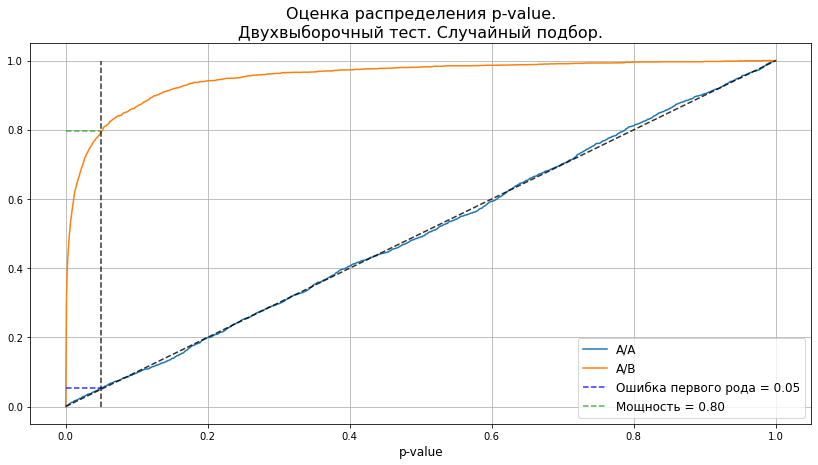

In [7]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_random, sample_size, calc_pvalue_iid
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Двухвыборочный тест. Случайный подбор.');

График показывает, что p-value в случае АА-теста распределён равномерно и уровень ошибок первого рода сохраняется на уровне 5%. А в случае, когда мы добавили синтетический эффект, мощность теста близка к 80%. Всё, как мы и ожидали.

## Неслучайный подбор групп

Несмотря на то, что в классическом случае мы получили верный результат, в левом нижнем углу графика собрались кейсы, которые мы вряд ли бы допустили в эксперимент (те случаи, когда выборки расходятся ещё до эксперимента). Обычно, чтобы не допустить случая расхождения групп на этапе их подбора, используются алгоритмы поиска похожих элементов. Давайте рассмотрим, как поведёт себя статистика в случае использования такого алгоритма.

О самом алгоритме сделаем предположение, что он в среднем подбирает похожие элементы, но в нём присутствует некоторый элемент случайности. То есть $x_a - x_b \sim N(0, \sigma_s)$.

При этом предположим, что стандартное отклонение подбора хотя бы в 2 раза меньше, чем стандартное отклонение генеральной совокупности $\sigma_s = 50$.

In [8]:
def select_samples_similar(sample_size, sigma_s=50):
    """Подбор "похожих" групп"""
    # дисперсии выборок
    var_x = var_y = sigma ** 2
    # ковариация
    var_xy = var_x - sigma_s ** 2
    cov_xy = (var_x + var_xy) / 2
    # генерация зависимых выборок
    mean = [mu, mu]
    cov = [[var_x, cov_xy], [cov_xy, var_y]]
    samples = np.random.multivariate_normal(mean, cov, sample_size)
    return samples

In [9]:
# Проверим, что никого не обманули
s = select_samples_similar(100000, sigma_s=50)
x = s[:, 0]
diff = s[:, 0] - s[:, 1]
print(f'Распределение выборки: mean = {x.mean():.1f}, std = {x.std():.1f}')
print(f'Распределение разностей: mean = {diff.mean():.1f}, std = {diff.std():.1f}')

Распределение выборки: mean = 999.7, std = 100.1
Распределение разностей: mean = -0.4, std = 50.1


100%|██████████| 2000/2000 [00:02<00:00, 756.95it/s]


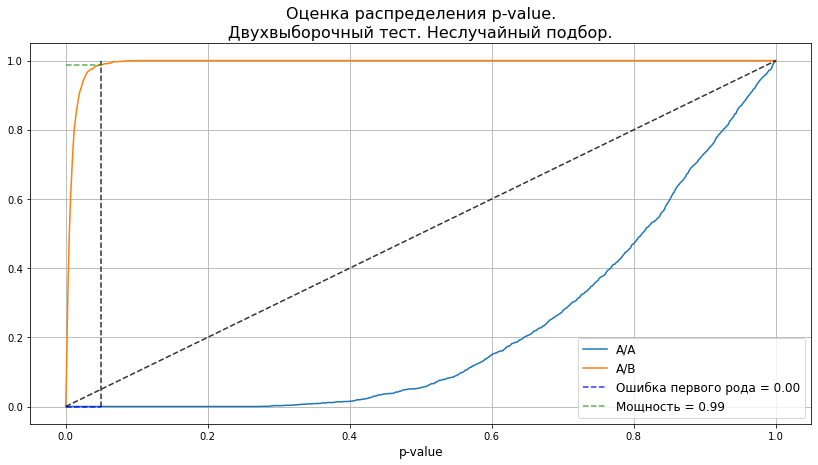

In [10]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_similar, sample_size, calc_pvalue_iid
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Двухвыборочный тест. Неслучайный подбор.');

График показывает, что такой алгоритм действительно улучшил результаты, и мы исключили случаи подбора статистически различных групп. Если говорить о пойманных эффектах, то мощность теста так же значительно подросла. То есть критерий Стьюдента для независимых выборок вроде и работает, а вроде и нет, так как мы получаем хоть и лучшие, но явно не те ошибки. Выборки-то у нас уже получились весьма зависимыми. А в случае зависимых выборок [предлагается](https://mse.msu.ru/wp-content/uploads/2020/03/Лекция-7-Две-выборки-дополнительный-материал.pdf) посмотреть в сторону одновыборочного критерия Стьюдента и применить его для попарных разностей зависимых элементов.

## Одновыборочный критерий попарных разностей

В данном случае мы переформулируем задачу. Заместо того, чтобы проверять нулевую гипотезу о том, что средние двух независимых выборок равны, поступим следующим образом:

1. Составим выборку попарных разностей $(d_1, ..., d_n)$, где $d_i=y_i - x_i$
2. $H_0: \mu_d = 0$, $H_1: \mu_d \neq 0$

В силу ЦПТ выборочное среднее выборки $d ~ N(\mu_d, \sigma_d)$.

Выглядит, как "перемена мест слагаемых" -- то есть мы просто взглянули на задачу под другим углом. А если это так, то этот критерий должен работать и в нашем классическом кейсе случайного подбора. Давайте в этом убедимся.

### Случайный подбор

Если из генеральной совокупности $N(\mu, \sigma)$ мы выберем 2 образца одинакового размера и поэлементно вычтем из одного другой, то мы получим выборку с распределением $N(0, \sqrt{2}\sigma)$.

In [11]:
# на всякий случай убедимся, что не врём
size = int(1e5)
a = dist_gen.rvs(size=size)
b = dist_gen.rvs(size=size)
diff = a - b

print(diff.std(), np.sqrt(2) * dist_gen.std())

141.3659519605756 141.4213562373095


Далее, воспользуемся [формулой](#sample_size_formula) расчёта размера выборки для одновыборочного критерия, которая должна дать нам тот же результат.

In [12]:
sample_size = calc_sample_size(mde, alpha, beta, np.sqrt(2) * sigma, one_sample=True)
print(sample_size)

6279


Ну и затем применим на случайных выборках одновыборочный критерий для попарных разностей.

In [13]:
def calc_pvalue_rel(samples):
    """Считаем уровень значимости в случае двух зависимых выборок"""
    return stats.ttest_rel(samples[:, 0], samples[:, 1])[1]

100%|██████████| 2000/2000 [00:02<00:00, 873.02it/s]


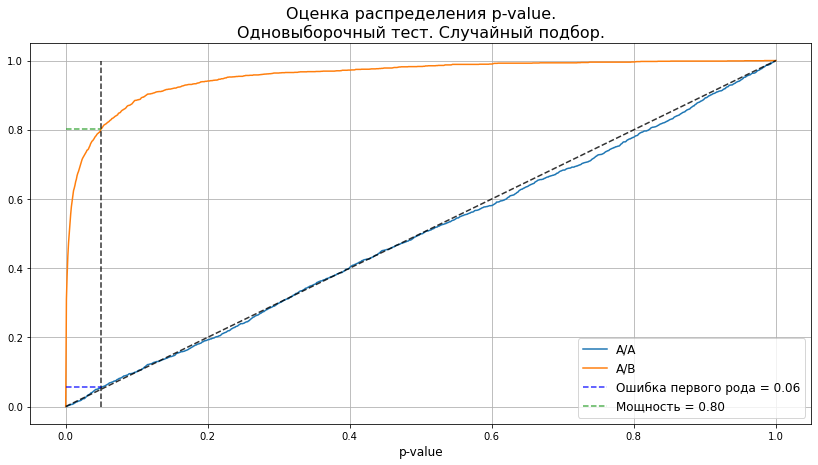

In [14]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_random, sample_size, calc_pvalue_rel
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Одновыборочный тест. Случайный подбор.');

Бинго, критерий работает! А значит, мы движемся в верном направлении и можем переходить к кейсу неслучайного подбора.

### Зависимые выборки

В нашем случае мы достоверно знаем, что дисперсия выборки попарных разностей будет равна заданной ($\sigma_s = 50$). Подставим в [формулу](#sample_size_formula) и посчитаем размер выборки.

In [15]:
sample_size = calc_sample_size(mde, alpha, beta, 50, one_sample=True)
print(sample_size)

784


Даже такое, казалось бы, незначительное снижение стандартного отклонения существенно сказывается на размере выборки. Это происходит в силу 2 факторов:
1. При случайном подборе, как мы говорили, отклонение разностей $\sigma_d = \sqrt{2} \sigma$. Поэтому даже если бы выбранным алгоритмом мы получили отклонение разностей $100$, то мы бы выиграли относительно случайного подбора, так как при случайном мы бы получили стандартное отклонение не $100$, а $\sim 141$.
2. Согласно [формуле](#sample_size_formula), зависимость размера выборки от стандартного отклонения носит квадратичный характер. Поэтому снижение этого отклонения в 2 раза приводит к 4-кратному снижению размера выборки.

Осталось проверить, действительно ли этой выборки хватит.

100%|██████████| 2000/2000 [00:01<00:00, 1512.65it/s]


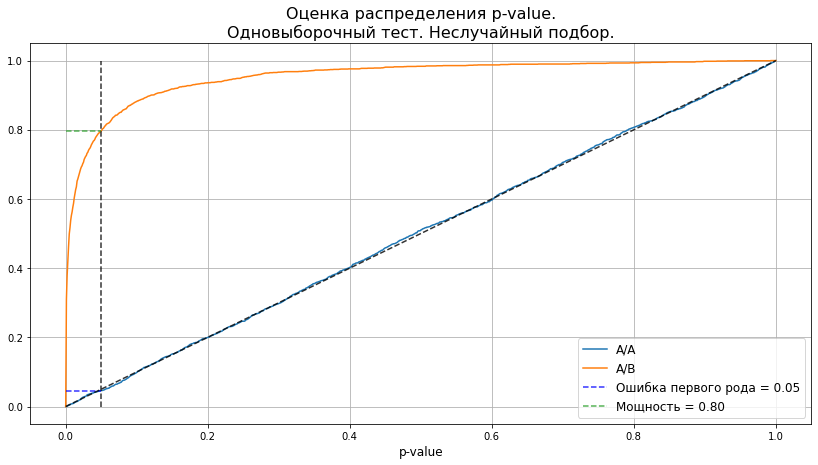

In [16]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_similar, sample_size, calc_pvalue_rel
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Одновыборочный тест. Неслучайный подбор.');

Получили знакомую нам верную картину. Таким образом, при значительном снижении размера выборки мы можем добиться заложенных при дизайне эксперимента уровней ошибок.

Но как мы помним, двухвыборочный тест в случае зависимых выборок тоже давал лучшие результаты. Давайте проверим, не сработает ли он для такого малого размера выборки?

100%|██████████| 2000/2000 [00:01<00:00, 1429.38it/s]


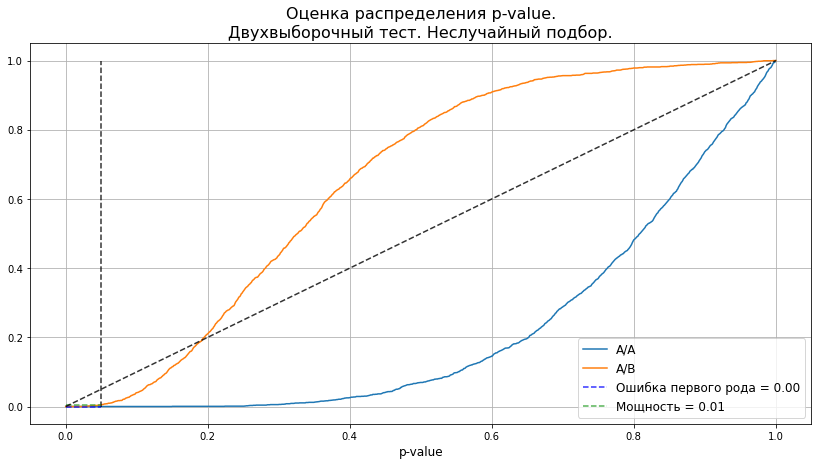

In [17]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_similar, sample_size, calc_pvalue_iid
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Двухвыборочный тест. Неслучайный подбор.');

Нет, как видим, двухвыборочный критерий для таких выборок не работает. Ошибка первого рода остаётся заниженной, а эффект мы обнаружить не можем.

## Теоретические итоги
<a id='theo_sumup'></a>

Итак, напомним, что у нас была генеральная совокупность, метрика на которой была распределена нормально $\sim N(1000, 100)$. На такой генеральной совокупности мы проводили синтетический эксперимент, для которого фиксировали следующие параметры:
* Ожидаемый эффект $\varepsilon = 5$
* $\alpha = 0.05$
* $\beta = 0.2$

Мы рассмотрели 2 варианта подбора и применили к ним 2 типа критериев. Результаты можно представить в таблице соответствия итоговых уровней ошибок заявленным:

||Двухвыборочный критерий|Одновыборочный критерий|
|--|--|--|
|Случайный подбор 6279 элементов|<font color='green'>Соответствует</font>|<font color='green'>Соответствует</font>|
|Подбор А под Б 6279 элементов|Завышенная чувствительность|Не проверяли|
|Подбор А под Б 784 элемента|<font color='red'>Невозможно поймать эффект</font>|<font color='green'>Соответствует</font>|

Итого, можно сказать следующее.

При использовании неслучайного алгоритма подбора групп можно использовать классический двухвыборочный тест Стьюдента. Проблема в том, что при оценке размера группы с использованием дисперсии генеральной совокупности, мы получим весьма завышенный размер группы. Как следствие, ошибки первого и второго рода в таком эксперименте будут сильно отличаться от заявленных, хоть и в меньшую сторону.

Одновыборочный же критерий Стьюдента хорошо себя чувствует как в классическом кейсе случайного подбора, так и в случае подбора одной выборки под другую. Аналогичные выводы можно найти в [статье от Авито](https://habr.com/ru/companies/avito/articles/571096/) в разделе про "парную стратификацию". Единственной проблемой остаётся оценка дисперсии алгоритма подбора. В наших теоретических кейсах мы задавали её руками, а вот в реальности её нужно будет как-то оценить.

Так что теория -- это хорошо. Но давайте проверим, насколько она применима к реальным данным.

## Реальные данные

Для проверки нашей теории на реальных данных были собраны 3 группы пользователей, соответствующие 3 последовательным временным периодам. Для каждого из этих периодов были посчитаны значения интересующей нас метрики, а также значения некоторых признаков пользователей, основанных на их поведении. Естественно, всё было нормированно.

In [18]:
users_features = pd.read_csv('users_features.csv')
users_features.head()

,period,user_id,target,prev_target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,2,0036ac61aa4f735c5788c7ec,-0.910249,-0.119530,0.984628,-0.621938,-0.595918,-0.176708,-0.258240,-0.694764,-0.004226
1,2,00378758ed8532102222ee40,0.918909,0.701929,0.984628,0.213634,0.302730,-0.176708,-0.117063,-0.533629,0.832616
2,2,004336d266ed48b416fb4cbb,0.238444,2.483253,-1.074538,0.878720,0.775439,-0.176708,0.588821,0.191482,2.647296
3,2,004abf8bb20a4202461ad0b0,-1.089998,-0.967098,-0.044955,-0.367145,-0.496387,-0.176708,-0.470006,-0.654481,-0.867665
4,2,004fb758cd6142b5df36e48e,-0.935878,-0.997215,-1.074538,-0.573228,-0.558286,-0.176708,-0.470006,-0.533629,-0.898346


<a id='target_distr'></a>

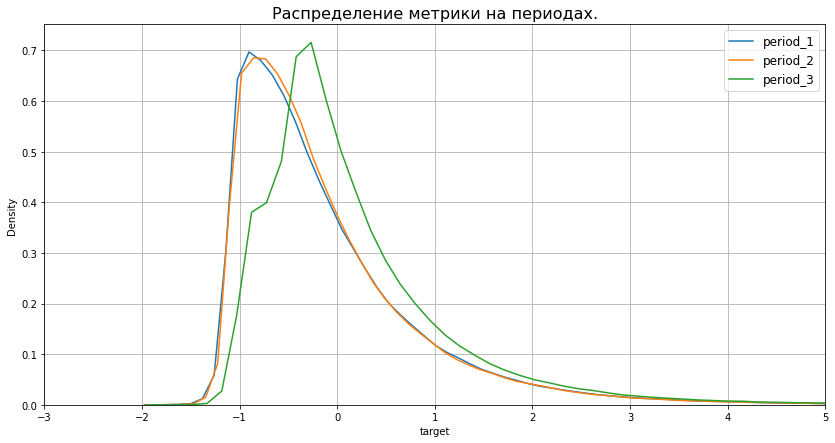

In [19]:
plt.figure(figsize=(14,7))
plt.title('Распределение метрики на периодах.', size=16)
for i in range(1, 4):
    sns.kdeplot(users_features.loc[users_features['period'] == i, 'target'], label=f'period_{i}')

plt.xlim(-3, 5)
plt.grid()
plt.legend(fontsize=12);

Из графика видно, что наша метрика распределена уже совсем не нормально, а на третьем периоде её распределение ещё и сильно отличается от двух предыдущих. Ну, тем веселее будет проверять.

### Алгоритм подбора групп

В реальности, помимо ненормальнисти распределения метрик мы сталкиваемся с ещё одной большой проблемой -- изменчивость данных с течением времени. Ведь группы мы подбираем раньше, чем проводим эксперимент.

Поэтому, для исследования алгоритма подбора нам потребуется 2 периода: на периоде 1 будем подбирать группы, а на периоде 2 будем проверять, насколько наши группы разошлись при условии, что уникальных воздействий ни на одну из групп не производилось.

In [20]:
data = users_features.loc[users_features['period'] == 2, :].drop(columns='period').dropna()
# отсортируем по размеру вектора признаков
data['sort_column'] = (data.iloc[:, 2:] ** 2).sum(axis=1)
data = data.sort_values('sort_column')

Данные готовы, осталось выбрать алгоритм. Я решил выбрать алгоритм подбора групп на основе близости пользователей по косинусному расстоянию между векторами их признаков. Давайте посмотрим, что у нас получается при использовании такого алгоритма.

In [21]:
def select_samples_pairwise(sample_size):
    """
    Пользователи в ЦГ набираются случайно из генеральной совокупности.
    Каждому пользователю в ЦГ подбирается максимально похожий в смысле косинусного расстояния 
    пользователь из ген.совокупности.
    """
    features_cols = [col for col in data.columns if 'feature' in col]
    # Разбиваем ген.совокупность на батчи
    data['group'] = np.arange(len(data)) // (len(data) / sample_size)
    # Инициализируем группы
    pg = pd.DataFrame()
    cg = pd.DataFrame()
    
    # Из каждого батча по 1 элементу в группы
    for _, group in data.groupby('group'):
        # Случайный элемент в пилот
        pg_sample = group.sample().drop(columns='group')
        pg_sample_vector = pg_sample[features_cols].values
        # Убираем выбранный элемент из группы
        general_sample = group.loc[group['user_id'] != pg_sample['user_id'].iloc[0], :]
        general_sample_vector = general_sample[features_cols].values
        # выбираем ближайший элемент в котнроль
        similarity = metrics.pairwise.cosine_similarity(pg_sample_vector, general_sample_vector)
        index = np.argmax(similarity)
        cg_sample = general_sample.iloc[[index], :].drop(columns='group')

        pg = pg.append(pg_sample)
        cg = cg.append(cg_sample)
    
    return cg, pg

In [22]:
%%time
# осуществим подбор групп размером в 1000 элементов 300 раз
test_size = 1000
cg, pg = select_samples_pairwise(test_size)
for _ in tqdm(range(50)):
    cg_l, pg_l = select_samples_pairwise(test_size)
    cg = pd.concat((cg, cg_l))
    pg = pd.concat((pg, pg_l))
# сформируем выборку попарных разностей
delta_preperiod = cg['prev_target'].to_numpy() - pg['prev_target'].to_numpy()
delta_pilot = cg['target'].to_numpy() - pg['target'].to_numpy()
sigma_d_fact = delta_pilot.std()

print(f'Характеристики генеральной совокупности: mu={data["target"].mean():.2f}, sigma={data["target"].std():.2f}')
print(f'Характеристики разностей на препериоде: mu={delta_preperiod.mean():.2f}, sigma={delta_preperiod.std():.2f}')
print(f'Характеристики разностей на периоде пилота: mu={delta_pilot.mean():.2f}, sigma={sigma_d_fact:.2f}')

100%|██████████| 50/50 [03:09<00:00,  3.80s/it]

Характеристики генеральной совокупности: mu=-0.09, sigma=0.98
Характеристики разностей на препериоде: mu=-0.00, sigma=0.15
Характеристики разностей на периоде пилота: mu=-0.01, sigma=0.81
CPU times: user 3min 11s, sys: 1.39 s, total: 3min 13s
Wall time: 3min 13s


<a id='real_data_dispersion'></a>
Видно, что в получившихся группах на периоде, где мы их подбирали, стандартное отклонение попарных разностей существенно меньше отклонения генеральной совокупности: 0.15 против 0.98. Но с течением времени группы начинают расходиться, и стандартное отклонение вырастает до 0.81, что в свою очередь всё же меньше, чем 0.98.

Изменчивость во времени также не даёт нам выбрать похожих пользователей только по одной целевой метрике. Это стандартная проблема переобучения: на периоде подбора наши группы получатся идеальными, но на следующем периоде группы существенно разойдутся. Давайте убедимся:

In [23]:
def select_samples_target(sample_size):
    """Подбор на основе близости таргета"""
    # Случайная пилотная группа
    pg = data.sample(sample_size).sort_values('prev_target')

    # Помечаем в генеральной совокупности случайный пилот
    general = data.sort_values('prev_target')
    general['pg'] = 0
    general.loc[general['user_id'].isin(pg['user_id']), 'pg'] = 1
    
    # Отбираем ближайших пользователей в контроль
    cg_users = []
    stack = 0
    for _, v in general.iterrows():
        if v['pg'] == 1:
            stack += 1
            continue
        if stack > 0:
            cg_users.append(v['user_id'])
            stack -= 1
            continue
    cg = general[general['user_id'].isin(cg_users)].sort_values('prev_target')
    
    return cg, pg

In [24]:
%%time
cg, pg = select_samples_target(30000)

delta_preperiod = cg['prev_target'].to_numpy() - pg['prev_target'].to_numpy()
delta_pilot = cg['target'].to_numpy() - pg['target'].to_numpy()
sigma_d_fact = delta_pilot.std()

print(f'Характеристики генеральной совокупности: mu={data["target"].mean():.2f}, sigma={data["target"].std():.2f}')
print(f'Характеристики разностей на препериоде: mu={delta_preperiod.mean():.2f}, sigma={delta_preperiod.std():.2f}')
print(f'Характеристики разностей на периоде пилота: mu={delta_pilot.mean():.2f}, sigma={sigma_d_fact:.2f}')

Характеристики генеральной совокупности: mu=-0.09, sigma=0.98
Характеристики разностей на препериоде: mu=0.00, sigma=0.00
Характеристики разностей на периоде пилота: mu=-0.01, sigma=0.98
CPU times: user 32.1 s, sys: 181 ms, total: 32.3 s
Wall time: 32.4 s


Как и ожидали. Дисперсия на периоде подбора практически нулевая, но вот на периоде, где мы собрались пилотироваться, она уже приближается к дисперсии ген.совокупности. Это, конечно, всё равно даёт нам выигрыш, так как при случайном подборе нам нужно будет умножать 0.98 на $\sqrt{2}$, но всё же, если подбирать похожих пользователей в более общем смысле, результат будет лучше.

### Эксперимент

Теперь давайте попробуем подтвердить нашу теорию на практике путём проведения синтетических тестов, и начнём с фиксации параметров эксперимента. Пусть мы хотим:
* отловить эффект $\varepsilon = 0.07$
* с ошибкой первого рода $\alpha = 0.05$
* и ошибкой второго рода $\beta = 0.2$

In [25]:
mde = 0.07
alpha = 0.05
beta = 0.2

Ранее [мы рассчитали](#real_data_dispersion) оценили cтандарное отклонение:
* генеральной совокупности $\sigma = 0.98$
* выборки попарных разностей $\sigma = 0.81$

Прикинем, сколько пользователей нам понадобилось бы для двухвыборочного теста при случайном подборе.

In [26]:
sample_size = calc_sample_size(mde, alpha, beta, 0.98, one_sample=False)
print(sample_size)

3076


А если мы будем использовать выбранный нами алгоритм подбора и воспользуемся одновыборочным критерием, то размер группы сократится приблизительно в 3 раза!

In [27]:
sample_size = calc_sample_size(mde, alpha, beta, 0.81, one_sample=True)
print(sample_size)

1050


Осталось только убедиться в том, что наш алгоритм действительно работает.

In [28]:
def select_samples_algo(sample_size):
    """Выбор ПГ и КГ из генеральной совокупности через косинусное расстояние"""
    cg, pg = select_samples_pairwise(sample_size)
    a = cg['target'].to_numpy().reshape(-1, 1)
    b = pg['target'].to_numpy().reshape(-1, 1)
    samples = np.concatenate((a, b), axis=1)
    return samples

100%|██████████| 300/300 [18:35<00:00,  3.72s/it]


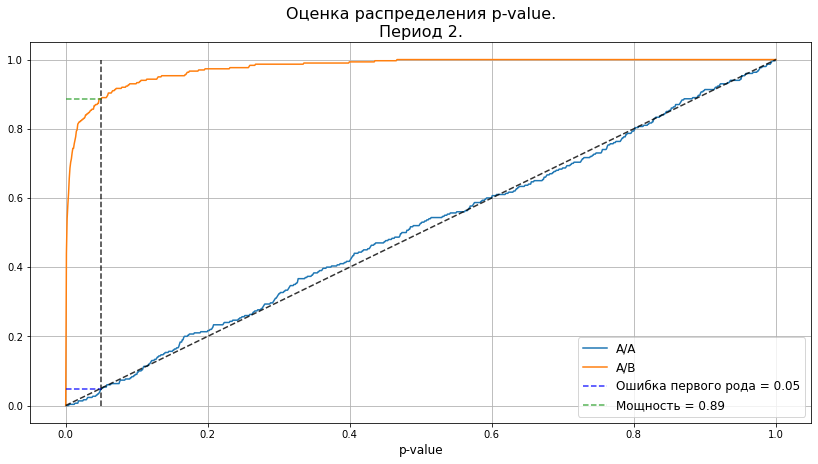

In [29]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_algo, sample_size, calc_pvalue_rel, n_boots=300
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Период 2.');

Уровень ошибок несколько отличается от заложенного. Это вызвано тем, что дисперсию мы всё-таки оценивали, а в самом подборе присутствует доля случайности. Но по графикам видно, что в целом, распределение p-value очень близко к виду, который мы получали на синтетике. А это говорит о том, что наша теория скорее работает, чем нет.

Осталось подсветить последний момент: использование периода 2 для эксперимента не совсем корректно, так как на нём мы оценивали дисперсию. В реальности, мы не можем знать насколько наши группы разойдутся на пилоте. Поэтому давайте посмотрим, насколько хорошо работает наша оценка дисперсии на периоде 3. При этом мы [помним](#target_distr), что само распределение метрики на периоде 3 существенно отличается от периодов 1 и 2.

In [30]:
data = users_features.loc[users_features['period'] == 3, :].drop(columns='period').dropna()
# отсортируем по размеру вектора признаков
data['sort_column'] = (data.iloc[:, 2:] ** 2).sum(axis=1)
data = data.sort_values('sort_column')

100%|██████████| 300/300 [25:44<00:00,  5.15s/it]


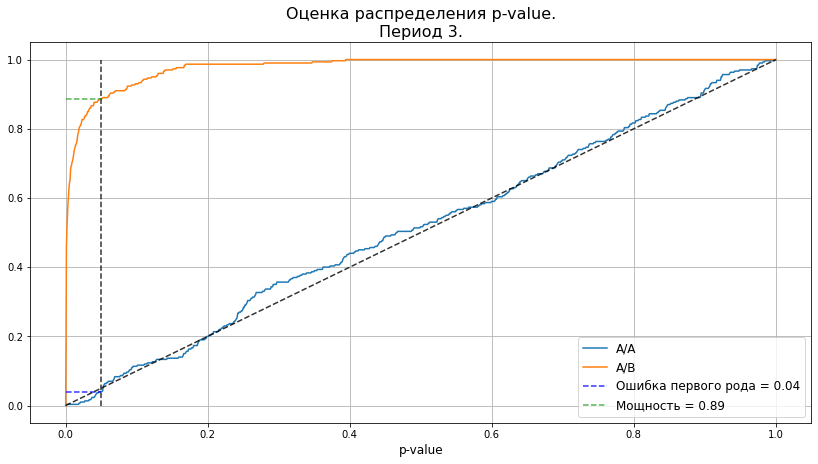

In [31]:
pvalues_aa, pvalues_ab = check_ttest(
    mde, select_samples_algo, sample_size, calc_pvalue_rel, n_boots=300
)
plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, 'Период 3.');

Даже на данных периода 3 реальность несильно уходит от наших предположений. Таким образом, у нас получилось сократить размер группы в 3 раза без потери качества эксперимента. Конечно, в текущем примере и 3 тысячи пользователей не выглядят катастрофой, но в данном примере малые размеры были выбраны намеренно, для ускорения расчётов. Если бы мы хотели поймать эффект порядка 0.01, то размеры выборки был бы порядка 100 тысяч пользователей. А в таком случае, сокращение объёма в 3 раза уже начинает играть роль.

## Итого

Основные [выводы](#theo_sumup) были озвучены к моменту, когда мы закончили исследовать синтетику и перешли к реальным данным. Во второй части статьи мы только подтверждали их на практике. А заключались они в следующем:

1. Если мы выбираем КГ и ЦГ из генеральной совокупности случайным образом, то ни к [формуле](#sample_size_formula) оценки размера групп, ни к двухвыборочному критерию Стьюдента вопросов нет.
2. В случае п.1 можно воспользоваться и одновыборочным критерием, от этого ничего не изменится. Главное -- не забыть умножить $\sigma$ на $\sqrt{2}$ при подсчёте размера выборки.
3. Если мы подбираем одну группу под другую, и пользуемся [формулой](#sample_size_formula), подставляя в неё дисперисию генеральной совокупности, то оценка размера групп будет завышенной. Использование двухвыборочного критерия будет слишком консервативным.
4. В случае поэлементного подбора одной группы под другую можно воспользоваться одновыборочным критерием Стьюдента для попарных разностей двух выборок. Такой подход позволит сократить размер выборки.

Спасибо за внимание:)